# ポアソン回帰に対するハミルトニアンモンテカルロ法

「Juliaで作って学ぶベイズ統計学」P.207 参照

In [1]:
using Distributions
using Plots
using ForwardDiff
using LinearAlgebra

eye(n) = Diagonal{Float64}(I, n)

eye (generic function with 1 method)

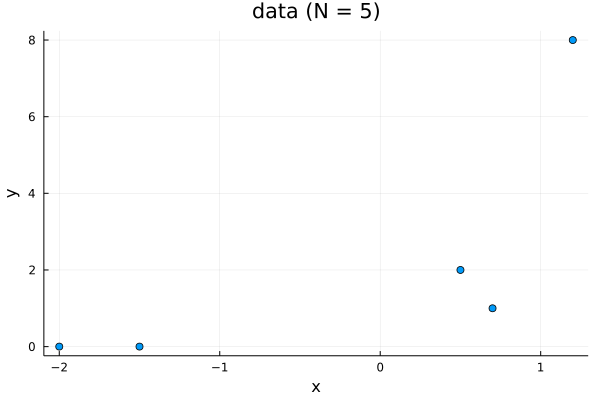

In [2]:
X_obs = [-2, -1.5, 0.5, 0.7, 1.2]
Y_obs = [0, 0, 2, 1, 8]
scatter(X_obs, Y_obs, xlab="x", ylab="y",
        label=:none, title="data (N = $(length(X_obs)))")

In [3]:
log_joint(w, X, Y) =
    sum(logpdf.(Poisson.(exp.(w[1] * X .+ w[2])), Y)) +
    logpdf(Normal(0, 1.0), w[1]) +
    logpdf(Normal(0, 1.0), w[2])
ulp(w) = log_joint(w, params...)

ulp (generic function with 1 method)

In [4]:
params = (X_obs, Y_obs)
w_init = randn(2)

2-element Vector{Float64}:
 -0.5556213495495215
 -0.3652927469071023

In [5]:
function hmc(log_p_tilde, μ₀, maxiter, L, ϵ)
    function leapflog(grad, p_in, μ_in, L, ϵ)
        μ = μ_in
        p = p_in + 0.5 * ϵ * grad(μ)
        for l in 1:L-1
            μ += ϵ * p
            p += ϵ * grad(μ)
        end
        μ += ϵ * p
        p += 0.5 * ϵ * grad(μ)
        p, μ
    end
    grad(μ) = ForwardDiff.gradient(log_p_tilde, μ)
    D = length(μ₀)
    μ_samples = Array{typeof(μ₀[1]), 2}(undef, D, maxiter)
    μ_samples[:, 1] = μ₀
    num_accepted = 1
    for i in 2:maxiter
        p_in = randn(size(μ₀))
        p_out, μ_out = leapflog(grad, p_in, μ_samples[:, i-1], L, ϵ)
        μ_in = μ_samples[:, i-1]
        log_r = (log_p_tilde(μ_out) +
                logpdf(MvNormal(zeros(D), eye(D)), vec(p_out))) -
                (log_p_tilde(μ_in) +
                logpdf(MvNormal(zeros(D), eye(D)), vec(p_in)))
        is_accepted = min(1, exp(log_r)) > rand()
        new_sample = is_accepted ? μ_out : μ_in
        μ_samples[:, i] = new_sample
        num_accepted += is_accepted
    end
    μ_samples, num_accepted
end

function inference_wrapper_hmc(log_joint, params, w_init, maxiter, L, ϵ)
    ulp(w) = log_joint(w, params...)
    hmc(ulp, w_init, maxiter, L, ϵ)
end


inference_wrapper_hmc (generic function with 1 method)

In [6]:
maxiter = 300
L = 10
ϵ = 1e-1

μ_samples, num_accepted = inference_wrapper_hmc(log_joint, params, w_init, maxiter, L, ϵ)

([-0.5556213495495215 2.151267528970912 … 2.0144448220247555 1.7177197366376697; -0.3652927469071023 -0.20705844546838215 … -0.7939457201904492 0.16416544543862355], 293)

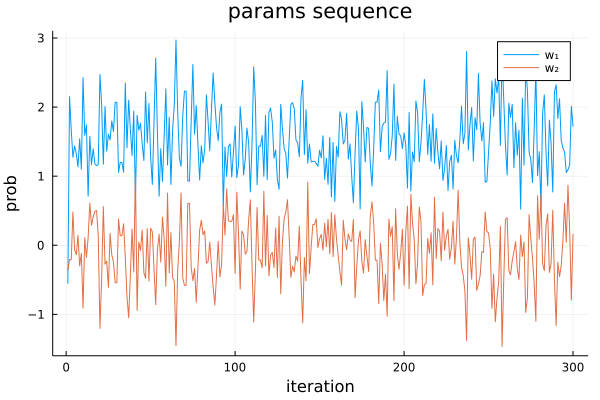

In [7]:
plot(μ_samples[1, :], xlab="iteration", ylab="prob", title="params sequence", label="w₁")
plot!(μ_samples[2, :], xlab="iteration", ylab="prob", title="params sequence", label="w₂")

In [8]:
w₁s = range(-5, 5, length=100)
w₂s = range(-5, 5, length=100);

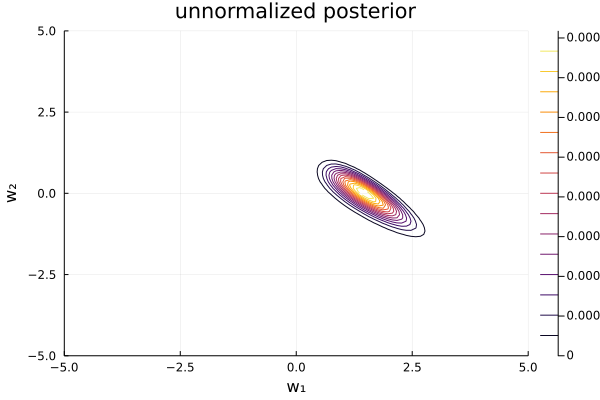

In [9]:
contour(w₁s, w₂s, [exp(ulp([w₁, w₂])) for w₁ in w₁s, w₂ in w₂s]',
        xlab="w₁", ylab="w₂", title="unnormalized posterior")

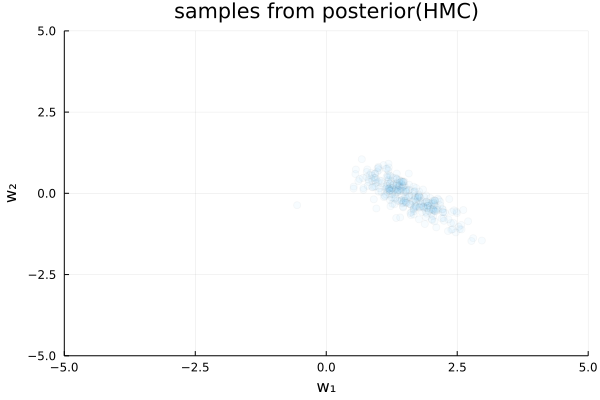

In [10]:
scatter(μ_samples[1, :], μ_samples[2, :], alpha=10/maxiter,
        xlim=(-5,5), ylim=(-5,5), xlab="w₁", ylab="w₂", title="samples from posterior(HMC)", label=:none)

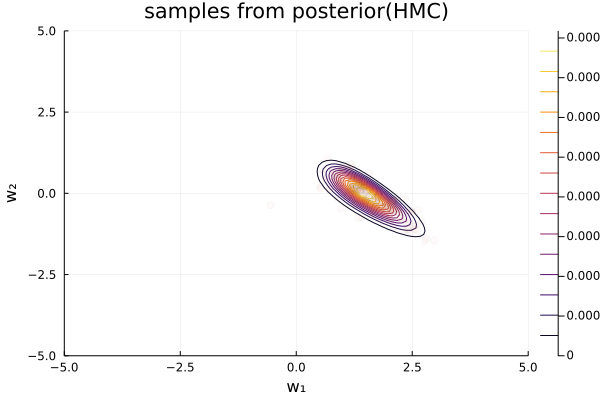

In [11]:
contour(w₁s, w₂s, [exp(ulp([w₁, w₂])) for w₁ in w₁s, w₂ in w₂s]', xlab="w₁", ylab="w₂")
scatter!(μ_samples[1, :], μ_samples[2, :], alpha=10/maxiter,
        xlim=(-5,5), ylim=(-5,5), xlab="w₁", ylab="w₂", title="samples from posterior(HMC)", label=:none)

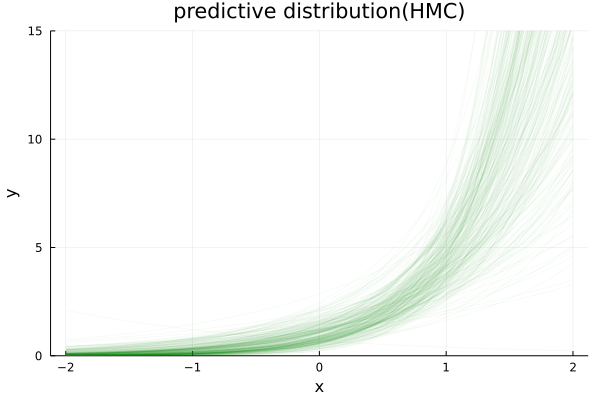

In [12]:
xs = range(-2, 2, length=100)
p = plot(xlab="x", ylab="y", title="predictive distribution(HMC)", ylim=(0, 15))
fs = []
for i in 1:size(μ_samples, 2)
    w₁, w₂ = μ_samples[:, i]
    f(x) = exp.(w₁ * x + w₂)
    push!(fs, f.(xs))
    p = plot!(xs, f.(xs), linecolor=:green, alpha=10/maxiter, label=:none)
end
p

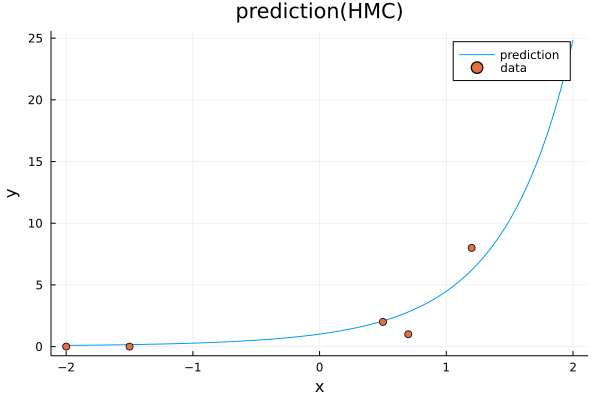

In [13]:
plot(xs, mean(fs), xlab="x", ylab="y", title="prediction(HMC)", label="prediction")
scatter!(X_obs, Y_obs, label="data")